In [6]:
import pandas as pd
import numpy as np

In [7]:
consumption_col = 'AEP_MW'

df = pd.read_csv('./rsc/AEP_hourly.csv')
df['Date'] = pd.to_datetime(df['Datetime'])
df = df.drop(columns=['Datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   AEP_MW  121273 non-null  float64       
 1   Date    121273 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB
None


# Classificazione rispetto alla media GLOBALE

In [8]:
global_mean = df[consumption_col].mean()
df['classification_global'] = np.where(df[consumption_col] >= global_mean, 'Alto Consumo', 'Basso Consumo')
print(df)

         AEP_MW                Date classification_global
0       13478.0 2004-12-31 01:00:00         Basso Consumo
1       12865.0 2004-12-31 02:00:00         Basso Consumo
2       12577.0 2004-12-31 03:00:00         Basso Consumo
3       12517.0 2004-12-31 04:00:00         Basso Consumo
4       12670.0 2004-12-31 05:00:00         Basso Consumo
...         ...                 ...                   ...
121268  21089.0 2018-01-01 20:00:00          Alto Consumo
121269  20999.0 2018-01-01 21:00:00          Alto Consumo
121270  20820.0 2018-01-01 22:00:00          Alto Consumo
121271  20415.0 2018-01-01 23:00:00          Alto Consumo
121272  19993.0 2018-01-02 00:00:00          Alto Consumo

[121273 rows x 3 columns]


# Classificazione rispetto alla media Settimanale

In [9]:
df['week'] = df['Date'].dt.isocalendar().week
df['year'] = df['Date'].dt.year
df['year_week'] = df['year'].astype(str) + '_' + df['week'].astype(str)
weekly_means = df.groupby('year_week')[consumption_col].mean()
df['weekly_mean'] = df['year_week'].map(weekly_means)
df['classification_weekly'] = np.where(df[consumption_col] >= df['weekly_mean'], 'Alto Consumo', 'Basso Consumo')
print(df)

         AEP_MW                Date classification_global  week  year  \
0       13478.0 2004-12-31 01:00:00         Basso Consumo    53  2004   
1       12865.0 2004-12-31 02:00:00         Basso Consumo    53  2004   
2       12577.0 2004-12-31 03:00:00         Basso Consumo    53  2004   
3       12517.0 2004-12-31 04:00:00         Basso Consumo    53  2004   
4       12670.0 2004-12-31 05:00:00         Basso Consumo    53  2004   
...         ...                 ...                   ...   ...   ...   
121268  21089.0 2018-01-01 20:00:00          Alto Consumo     1  2018   
121269  20999.0 2018-01-01 21:00:00          Alto Consumo     1  2018   
121270  20820.0 2018-01-01 22:00:00          Alto Consumo     1  2018   
121271  20415.0 2018-01-01 23:00:00          Alto Consumo     1  2018   
121272  19993.0 2018-01-02 00:00:00          Alto Consumo     1  2018   

       year_week   weekly_mean classification_weekly  
0        2004_53  16419.700000         Basso Consumo  
1        2004

# Classificazione rispetto alla media GIORNALIERA

In [10]:
daily_means = df.groupby('Date')[consumption_col].mean()
df['daily_mean'] = df['Date'].map(daily_means)
df['classification_daily'] = np.where(df[consumption_col] >= df['daily_mean'], 'Alto Consumo', 'Basso Consumo')
# df = df.drop(columns=['daily_mean'])
print(df)

         AEP_MW                Date classification_global  week  year  \
0       13478.0 2004-12-31 01:00:00         Basso Consumo    53  2004   
1       12865.0 2004-12-31 02:00:00         Basso Consumo    53  2004   
2       12577.0 2004-12-31 03:00:00         Basso Consumo    53  2004   
3       12517.0 2004-12-31 04:00:00         Basso Consumo    53  2004   
4       12670.0 2004-12-31 05:00:00         Basso Consumo    53  2004   
...         ...                 ...                   ...   ...   ...   
121268  21089.0 2018-01-01 20:00:00          Alto Consumo     1  2018   
121269  20999.0 2018-01-01 21:00:00          Alto Consumo     1  2018   
121270  20820.0 2018-01-01 22:00:00          Alto Consumo     1  2018   
121271  20415.0 2018-01-01 23:00:00          Alto Consumo     1  2018   
121272  19993.0 2018-01-02 00:00:00          Alto Consumo     1  2018   

       year_week   weekly_mean classification_weekly  daily_mean  \
0        2004_53  16419.700000         Basso Consumo   


Classification Report:
               precision    recall  f1-score   support

 Alto Consumo       0.87      0.89      0.88     12633
Basso Consumo       0.87      0.86      0.87     11622

     accuracy                           0.87     24255
    macro avg       0.87      0.87      0.87     24255
 weighted avg       0.87      0.87      0.87     24255


Confusion Matrix:
[[11208  1425]
 [ 1674  9948]]


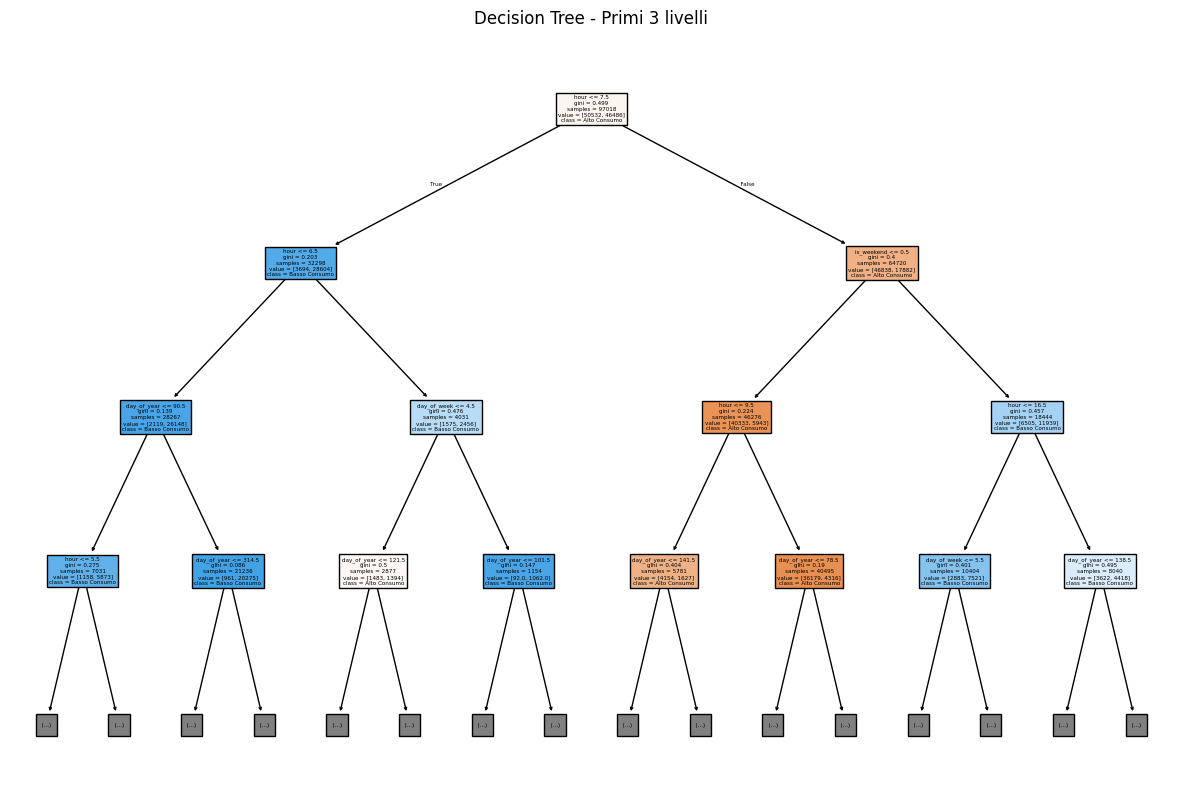

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Preparazione delle features dalla colonna Date
df['hour'] = df['Date'].dt.hour
df['day_of_week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Seleziona le features derivate dalla Date
features = ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend']
# features = ['Date']
X = df[features]
y = df['classification_weekly']

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42, stratify=y
)

# Crea e allena il Decision Tree
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,  # Limita la profondità per evitare overfitting
    min_samples_split=20,
    min_samples_leaf=10
)

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

# Valutazione del modello
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualizza l'albero decisionale (primi livelli)
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, 
          feature_names=features,
          class_names=['Alto Consumo', 'Basso Consumo'],
          filled=True,
          max_depth=3)  # Mostra solo i primi 3 livelli
plt.title("Decision Tree - Primi 3 livelli")
plt.show()